In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from tqdm import tqdm
import pandas as pd
from scipy.integrate import trapezoid
from scipy.optimize import curve_fit
from scipy.special import jv

In [2]:
plt.rcParams.update({'font.size': 10})
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
plt.rcParams.update({
    "text.usetex": True,
})

In [3]:
def linear(x, a, b):
    return a*x+b

In [4]:

def apodization_function(theta, focus=3.1e-3, theta_max=np.arcsin(0.67), w_0=(5.5e-3)/2):
    f_0 = w_0/(focus*np.sin(theta_max))
    return np.exp(-np.power(np.sin(theta)/(f_0*np.sin(theta_max)),2))


def integral_i_00(rho, theta, z, focus=3.1e-3, theta_max=np.arcsin(0.67), wavenumber=2*np.pi/(1550e-9)):
    fw = apodization_function(theta, focus=focus, theta_max=theta_max)
    return fw*np.sqrt(np.cos(theta))*np.sin(theta)*(1+np.cos(theta))*jv(0, wavenumber*rho*np.sin(theta))*np.exp(1j*wavenumber*z*np.cos(theta))


def integral_i_01(rho, theta, z, focus=3.1e-3, theta_max=np.arcsin(0.67), wavenumber=2*np.pi/(1550e-9)):
    fw = apodization_function(theta, focus=focus, theta_max=theta_max)
    return fw*np.sqrt(np.cos(theta))*np.power(np.sin(theta),2)*jv(1, wavenumber*rho*np.sin(theta))*np.exp(1j*wavenumber*z*np.cos(theta))


def integral_i_02(rho, theta, z, focus=3.1e-3, theta_max=np.arcsin(0.67), wavenumber=2*np.pi/(1550e-9)):
    fw = apodization_function(theta, focus=focus, theta_max=theta_max)
    return fw*np.sqrt(np.cos(theta))*np.sin(theta)*(1-np.cos(theta))*jv(2, wavenumber*rho*np.sin(theta))*np.exp(1j*wavenumber*z*np.cos(theta))


def compute_electric_field(rho, phi, z, focus=3.1e-3, theta_max=np.arcsin(0.67), wavenumber=2*np.pi/(1550e-9)):
    thetas = np.linspace(0, theta_max, 1000)
    i_00 = trapezoid(integral_i_00(rho, thetas, z), thetas)
    i_01 = trapezoid(integral_i_01(rho, thetas, z), thetas)
    i_02 = trapezoid(integral_i_02(rho, thetas, z), thetas)
    E_amp = (1j*wavenumber*focus/2)*np.exp(-1j*wavenumber*focus)
    return E_amp*np.array([[i_00+i_02*np.cos(2*phi)],[i_02*np.sin(2*phi)],[-2j*i_01*np.cos(phi)]])

def compute_intensity_profile(xs, ys, z=0, power=200e-3, initial_waist=5.5e-3/2, epsilon_0=8.85e-12, c=3e8):
    xs, ys = np.meshgrid(xs, ys)
    rhos = np.sqrt(np.power(xs,2)+np.power(ys,2))
    phis = np.arctan2(ys, xs)
    E_0 = np.sqrt(4*power/(initial_waist*initial_waist*np.pi*epsilon_0*c))
    intensities = np.zeros(rhos.shape)
    for i in range(rhos.shape[0]):
        for j in range(rhos.shape[1]):
            module_e = E_0*np.abs(compute_electric_field(rhos[i,j], phis[i,j], z))
            intensity = c*epsilon_0*np.power(module_e,2).sum()/2
            intensities[i, j] =intensity
    return xs, ys, intensities


def compute_intensity_z(z,  power=200e-3, initial_waist=5.5e-3/2, epsilon_0=8.85e-12, c=3e8):
    rho = 0
    phi = 0
    E_0 = np.sqrt(4*power/(initial_waist*initial_waist*np.pi*epsilon_0*c))
    intensities = np.zeros(z.shape)
    for i in range(z.shape[0]):
        module_e = E_0*np.abs(compute_electric_field(rho, phi, z[i]))
        intensity = c*epsilon_0*np.power(module_e,2).sum()/2
        intensities[i] =intensity
    return intensities


In [5]:
R = (143e-9)/2
epsilon_0 = 8.85e-12
refraction_index = 1.55
wavelength = 1550e-9
wavenumber = 2*np.pi/wavelength
c = 2.99e8
epsilon = refraction_index**2
rho = 2200
power = 300e-3
volume = 4 * np.pi * np.power(R,3)/ 3
m = rho * volume
epsilon_ratio = (epsilon-1)/(epsilon+2)
alpha_CM = 3 * volume * epsilon_0 * epsilon_ratio
alpha = alpha_CM/(1-epsilon_ratio*(np.power(wavenumber*R,2)+(2j/3)*np.power(wavenumber*R,3)))

In [8]:
def compute_forces_xy(x_points, y_points, intensities, alpha):
    fx = np.gradient(intensities[:, int(intensities.shape[1]/2)], np.diff(x_points)[0])
    fy = np.gradient(intensities[int(intensities.shape[1]/2),:], np.diff(y_points)[0])
    return np.real(alpha)*fx/(2*c*epsilon_0), np.real(alpha)*fy/(2*c*epsilon_0)

def compute_forces_z(z_points, intensities, alpha, wavenumber=(2*np.pi/(1550e-9)), radius=143e-9/2, epsilon_0=8.85e-12, c=3e8):
    f_grad_z = np.gradient(intensities, np.diff(z_points)[0])
    f_grad_z = np.real(alpha)*f_grad_z/(2*c*epsilon_0)
    f_scat = np.imag(alpha)*wavenumber*intensities/(c*epsilon_0)
    return f_grad_z, f_scat 

In [9]:
z_points = np.linspace(-10e-6, 10e-6, 150)
intensities = compute_intensity_z(z_points)
f_grad_z, f_scat = compute_forces_z(z_points, intensities, alpha, radius=R)


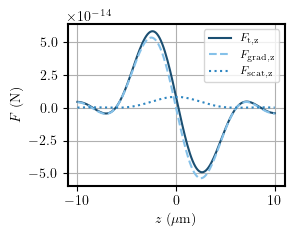

In [26]:
colors = ['#2E86C1', '#85C1E9', '#1B4F72']
fig = plt.figure(figsize=(5.4*1.3*10, 10*4.2))
factor = 0.7
fig.set_size_inches(4*factor, 3*factor, forward=True)
plt.plot(z_points/1e-6,f_grad_z+f_scat, color=colors[2])
plt.plot(z_points/1e-6, f_grad_z, color=colors[1], linestyle='dashed')
plt.plot(z_points/1e-6, f_scat, color=colors[0], linestyle='dotted')


#plt.plot(np.gradient(intensities)[:, int(ys.shape[1]/2)], color=colors[2], linestyle='dashed')
plt.xlabel(r'$z$ ($\mu$m)')
plt.ylabel(r'$F$ ($\textrm{N}$)') 
plt.xticks([-10, 0, 10])
plt.grid()
plt.legend([r'$F_{\rm{t},z}$' ,r'$F_{\rm{grad},z}$', r'$F_{\rm{scat},z}$'], loc='upper right', fontsize=8)
plt.savefig('plots/Chapter 2/forces_z_no_fit.pdf', dpi=300, bbox_inches = 'tight')
plt.show()
plt.show()

In [13]:
f_total_z = f_grad_z+f_scat
#params, _ = curve_fit(linear, x_points,  intensities[:, int(ys.shape[1]/2)], p0=[300e-3, 1.5e-6])

params, _ = curve_fit(linear, z_points[75-7:75+7], f_total_z[75-7:75+7], p0=[1e-15, 0])
np.sqrt(-params[0]/m)/(2*np.pi)

15788.403308558496

In [24]:
z_0 = -params[1]/params[0]
z_0

2.4822484539888537e-07

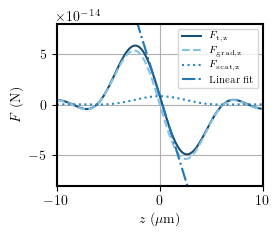

In [57]:
colors = ['#2E86C1', '#85C1E9', '#1B4F72']
fig = plt.figure(figsize=(5.4*1.3*10, 10*4.2))
factor = 0.7
fig.set_size_inches(3.8*factor, 3*factor, forward=True)
plt.plot(z_points/1e-6,f_grad_z+f_scat, color=colors[2])
plt.plot(z_points/1e-6, f_grad_z, color=colors[1], linestyle='dashed')
plt.plot(z_points/1e-6, f_scat, color=colors[0], linestyle='dotted')
plt.plot(z_points/1e-6, linear(z_points, *params), linestyle='-.')

plt.xlim([-10,10])
plt.ylim([-8e-14, 8e-14])
#plt.plot(np.gradient(intensities)[:, int(ys.shape[1]/2)], color=colors[2], linestyle='dashed')
plt.xlabel(r'$z$ ($\mu$m)')
plt.ylabel(r'$F$ ($\textrm{N}$)') 
plt.xticks([-10, 0, 10])
plt.grid()
plt.legend([r'$F_{\rm{t},z}$' ,r'$F_{\rm{grad},z}$', r'$F_{\rm{scat},z}$', 'Linear fit'], loc='upper right', fontsize=7)
plt.savefig('plots/Chapter 2/forces_z_fit.pdf', dpi=300, bbox_inches = 'tight')
plt.show()
plt.show()


In [51]:
na = 0.67
theta_max = np.arcsin(0.67)
focus = 3.1e-3

x_points = np.linspace(-2.2e-6, 2.2e-6, 150)
y_points = np.linspace(-2.2e-6, 2.2e-6, 150)
xs, ys, intensities = compute_intensity_profile(x_points, y_points, z=z_0)
fy, fx = compute_forces_xy(x_points, y_points, intensities, alpha)

In [52]:
#params, _ = curve_fit(linear, x_points,  intensities[:, int(ys.shape[1]/2)], p0=[300e-3, 1.5e-6])

params_x, _ = curve_fit(linear, x_points[75-7:75+7], fx[75-7:75+7], p0=[1e-15, 0])
params_y, _ = curve_fit(linear, y_points[75-7:75+7], fy[75-7:75+7], p0=[1e-15, 0])

np.sqrt(-params_x[0]/m)/(2*np.pi),np.sqrt(-params_y[0]/m)/(2*np.pi)

/Users/oscarkremer/miniconda3/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


(63104.66869758479, 70244.61762670192)

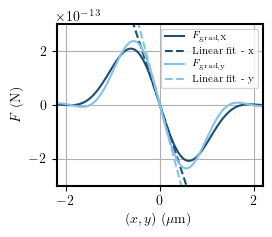

In [58]:
colors = ['#2E86C1', '#85C1E9', '#1B4F72']
fig = plt.figure(figsize=(5.4*1.3*10, 10*4.2))
factor = 0.7
fig.set_size_inches(3.8*factor, 3*factor, forward=True)

plt.plot(x_points/1e-6, fx, color=colors[2])
plt.plot(x_points/1e-6, linear(x_points, *params_x), color=colors[2], linestyle='dashed')
plt.plot(y_points/1e-6, fy, color=colors[1])
plt.plot(y_points/1e-6, linear(y_points, *params_y), color=colors[1], linestyle='dashed')

plt.xlim([-2.2, 2.2])
plt.ylim([-3e-13, 3e-13])
#plt.plot(np.gradient(intensities)[:, int(ys.shape[1]/2)], color=colors[2], linestyle='dashed')
plt.xlabel(r'$(x,y)$ ($\mu$m)')
plt.ylabel(r'$F$ ($\textrm{N}$)') 
plt.xticks([-2, 0, 2])
plt.grid()
plt.legend([r'$F_{\rm{grad},X}$' ,r'Linear fit - x', r'$F_{\rm{grad},y}$', 'Linear fit - y'], loc='upper right', fontsize=7)
plt.savefig('plots/Chapter 2/forces_xy_fit.pdf', dpi=300, bbox_inches = 'tight')
plt.show()
plt.show()